# Desafío - Análisis lineal discriminante
- Para realizar este desafío debes haber estudiado previamente todo el material disponibilizado correspondiente a la unidad.
- Una vez terminado el desafío, comprime la carpeta que contiene el desarrollo de los requerimientos solicitados y sube el .zip en el LMS.
- Desarrollo desafío:
    - El desafío se debe desarrollar de manera Individual.
    - Para la realización del desafío necesitarás apoyarte del archivo Apoyo Desafío - Análisis lineal discriminante.

## Requerimientos
Trabajaremos con una base de datos sobre clientes morosos de un banco. Dentro de ésta se registran las siguientes observaciones:
- `default`: Variable Binaria. Registra si el cliente entró en morosidad o no.
- `income`: Ingreso promedio declarado por el cliente.
- `balance`: total del saldo en la cuenta de crédito.
- `student`: Variable binaria. Registra si el cliente es estudiante o no.

### Ejercicio 1: Preparación de ambiente de trabajo
- Importe los módulos básicos para el análisis de datos.
- Importe las clases `LabelEncoder`, `StandardScaler` y `LabelBinarizer` de `preprocessing`.
- Importe las funciones `train_test_split` y `cross_val_score` de `model_selection`.
- Importe la función `classification_report` de metrics.
- Importe las clases `LinearDiscriminantAnalysis` y `QuadraticDiscriminantAnalysis`.
- Agregue la base de datos en el ambiente de trabajo.
- Inspeccione la distribución de cada atributo.

In [1]:
# Utiliza esta celda para importar los módulos y datos

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, LabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from funciones import graf_pie, hist_and_box, porcentaje_null, matriz_confusion
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('default_credit.csv').drop('index', axis=1)
df

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879
...,...,...,...,...
9995,No,No,711.555020,52992.378914
9996,No,No,757.962918,19660.721768
9997,No,No,845.411989,58636.156984
9998,No,No,1569.009053,36669.112365


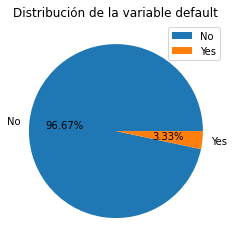

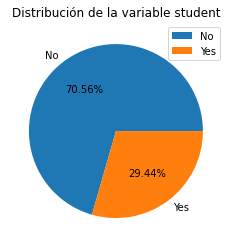

In [2]:
# Utiliza esta celda para inspeccinar las distribuciones de los atributos (puede usar más celdas)
# Primero, veremos las distribuciones de las variables categóricas:

for col in ['default','student']:
    graf_pie(df, col)

**Comentarios: Claramente, vemos un desbalanceo demasiado grande en nuestra variable objetivo, donde los `no morosos` concentran aprox. el 96% de la data. Por otro lado, vemos que claramente hay mas clientes que no son estudiantes.**

No handles with labels found to put in legend.


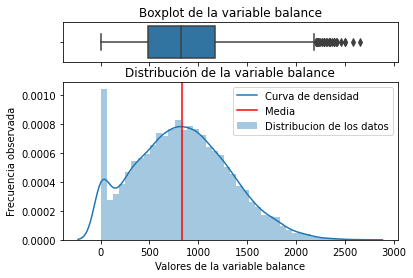

No handles with labels found to put in legend.


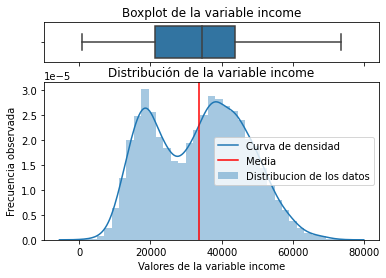

In [3]:
# Luego, vemos las distribuciones de las variables numéricas:

for col in ['balance','income']:
    hist_and_box(df, col)

**Comentarios: vemos que para la variable `balance`, existen muchos clientes con saldo 0 en la cuenta de crédito, además de presentar valores outliers cargados en su cola derecha. Para la variable `income`, vemos como pose ingreso muy concentado entre los 20.000 y 40.000, sin presentar valores outliers.**

In [4]:
# Por último, vemos si es que existen datos nulos en la data

porcentaje_null(df)

         N_NaN  Porcentaje
default      0         0.0
student      0         0.0
balance      0         0.0
income       0         0.0


**Comentarios: No existem datos nulos en la data.**

### Ejercicio 2: Modelo base
- Recuerde que los modelos de `sklearn` no soportan datos que no sean numéricos. Transforme los atributos pertinentes con `LabelEncoder`.
- Genere muestras de validación y entrenamiento, reservando un 33% de los datos como validación.
- Genere un modelo con `LinearDiscriminantAnalysis` sin modificar los hiper parámetros.
- Genere métricas de evaluación utilizando `classification_report`.
- Comente sobre cuál es el desempeño del modelo en cada clase, así como en general.

In [5]:
# Utiliza esta celda para pre procesar los datos

df['default'] = LabelEncoder().fit_transform(df['default'])
df['student'] = LabelEncoder().fit_transform(df['student'])

df.head()

,default,student,balance,income
0,0,0,729.526495,44361.625074
1,0,1,817.180407,12106.134700
2,0,0,1073.549164,31767.138947
3,0,0,529.250605,35704.493935
4,0,0,785.655883,38463.495879


In [6]:
# Utiliza esta celda para separar las muestras

df_y = df['default']
df_x = df.drop('default', axis=1)

X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.33, random_state=13)

In [7]:
# Utiliza esta celda para instanciar y entrenar el modelo

model_lda = LinearDiscriminantAnalysis().fit(X_train,y_train)

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      3181
           1       0.81      0.29      0.42       119

    accuracy                           0.97      3300
   macro avg       0.89      0.64      0.70      3300
weighted avg       0.97      0.97      0.97      3300



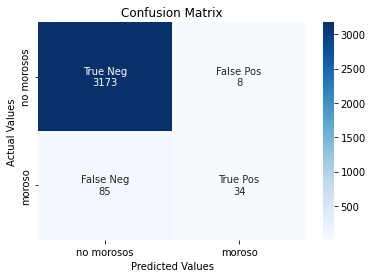

In [8]:
# Utiliza esta celda para explorar las métricas de desempeño del modelo entrenado

y_pred = model_lda.predict(X_test)

print(classification_report(y_test, y_pred))

matriz_confusion(y_test, y_pred)

**Comentarios:**

- El modelo tiene un excelente accuracy, de un 97%, casi perfecto.
- Además, la clase mayoritaria la logra capturar de muy buena forma, con una precision de uin 97% y con un recall de casi perfecto, practicqamente de un 100%.
- Por último, la clase que nos interesa predecir, los morosos, tiene una muy buena precision de un 81% pero un muy bajo recall, de una 29%; lo que significa que el modelo sólo logra capturar un bajo porcentaje de morosos.

Esto se debe a un claro problema de desbalanceo de datos, como se aprecia en la distribucion de la variable objetivo `default`.

### Ejercicio 3: Refactorización 1 - información a priori
- Dado que trabajamos con modelos generativos, podemos incluir información exógena. Para este caso agregaremos dos distribuciones (**Tip**: Revise la lectura 2 para revisar el uso del parámetro `priors`):
    - Asumamos que hay un 50/50 de morosos y no morosos.
    - Asumamos que hay un 60/40 de morosos y no morosos.
- Por cada modelo, reporte las métricas de clasificación.

In [9]:
# Utiliza esta celda para entrenar los dos modelos solicitados

model_lda_pri_5050 = LinearDiscriminantAnalysis(priors=[.5, .5]).fit(X_train,y_train)
model_lda_pri_6040 = LinearDiscriminantAnalysis(priors=[.6, .4]).fit(X_train,y_train)

In [10]:
# Utiliza esta celda para explorar las métricas del primer modelo solicitado en este item

y_pred_pri_5050 = model_lda_pri_5050.predict(X_test)
print(classification_report(y_test, y_pred_pri_5050))

              precision    recall  f1-score   support

           0       0.99      0.84      0.91      3181
           1       0.17      0.87      0.28       119

    accuracy                           0.84      3300
   macro avg       0.58      0.85      0.60      3300
weighted avg       0.96      0.84      0.89      3300



In [11]:
# Utiliza esta celda para explorar las métricas del segundo modelo solicitado en este item

y_pred_pri_6050 = model_lda_pri_6040.predict(X_test)
print(classification_report(y_test, y_pred_pri_6050))

              precision    recall  f1-score   support

           0       0.99      0.88      0.93      3181
           1       0.20      0.79      0.31       119

    accuracy                           0.88      3300
   macro avg       0.59      0.83      0.62      3300
weighted avg       0.96      0.88      0.91      3300



**Comentarios**

- En ambos modelos el accuracy disminuye (84% y 88% para el modelo 50/50 y 60/40 respectivamente), pero mejora la precision de la clase mayoritaria a un 99% (no morosos)
- Para la clase de interés (morosos), si bien la precisión disminuye en ambos modelos (17% y 20% para el modelo 50/50 y 60/40 respectivamente), el recall mejora considerablemente, aunque el f1-score tambien disminuye para esta clase.

### Ejercicio 4: Refactorización 2 - oversampling

**Digresión: Synthetic Over(Under)Sampling**
- Por lo general podemos intentar aliviar el problema del desbalance de clases mediante la ponderación dentro del algoritmo. Otra alternativa es el muestreo con reemplazo dentro de los conjuntos de entrenamiento. Estos métodos clásicos se conocen como _Oversampling_ cuando repetimos registros aleatorios de la clase minoritaria, y _Undersampling_ cuando eliminamos aleatoriamente registros de la clase mayoritaria.
<br />

- Un contratiempo de estos métodos clásicos es que pueden replicar información sesgada que afecte el desempeño de generalización del modelo. Si los datos son malos, estaremos replicando estas fallas.
<br />

- Otra solución es generar ejemplos de entrenamiento sintéticos mediante el entrenamiento de ejemplos de la clase minoritaria. A grandes rasgos la solución funciona de la siguiente forma:
    - En función a un subconjunto de datos correspondientes a la clase minoritaria, entrenamos algún modelo no supervisado o generativo como Naive Bayes, KMeans o KNearestNeighbors para generar representaciones sintéticas de los datos en el espacio de atributos de la clase específica mediante $x_{\text{nuevo-ejemplo}} = x_i + \lambda(x_{zi} - x_i)$ es un ejemplo de entrenamiento de la clase minoritaria, y $\lambda$ es un parámetro de interpolación aleatorio $\lambda \sim \text{Uniforme}(0, 1)$.
<br />

- Uno de los problemas más graves de esta base de datos, es el fuerte desbalance entre clases. Ahora generaremos observaciones sintéticas mediante `SMOTE` (Synthetic Minority Oversampling Technique). Para ello, debemos agregar el paquete a nuestro ambiente virtual. En nuestro terminal agregamos `conda install -c conda-forge imbalanced-learn` (puede también usar una celda de código de Jupyter Notebook anteponiendo `!`. Alternativamente también se puede usar `pip install imbalanced-learn`). Incorpore `SMOTE` en el ambiente de trabajo con la siguiente sintáxis `from imblearn.over_sampling import SMOTE`.
<br />

- Para implementar oversampling, debemos generar nuevos objetos que representan nuestra muestra de entrenamiento incrementada artificialmente. Para ello implemente la siguiente sintaxis:
```python
from imblearn.over_sampling import SMOTE
# Instanciamos la clase
oversampler = SMOTE(random_state=11238, ratio='minority')
# generamos el oversampling de los datos de entrenamiento
X_train_oversamp, y_train_oversamp = oversampler.fit_sample(X_train, y_train)
```

- Vuelva a entrenar el modelo con los datos aumentados de forma artificial y comente sobre su desempeño.

In [12]:
# Utiliza esta celda para aplicar oversampling

from imblearn.over_sampling import SMOTE
from collections import Counter

oversample = SMOTE(sampling_strategy='minority', random_state=13)

X_train_oversamp, y_train_oversamp = oversample.fit_resample(X_train, y_train)

print("y_train antes de aplicar SMOTE: ", Counter(y_train))
print("y_train despues de aplicar SMOTE: ", Counter(y_train_oversamp))

y_train antes de aplicar SMOTE:  Counter({0: 6486, 1: 214})
y_train despues de aplicar SMOTE:  Counter({0: 6486, 1: 6486})


In [13]:
# Utiliza esta celda para entrenar el modelo con datos oversampleados

model_lda_smote = LinearDiscriminantAnalysis().fit(X_train_oversamp,y_train_oversamp)

In [14]:
# Utiliza esta celda para evaluar las métricas de desempeño del modelo con datos oversampleados

y_pred_lda_smote = model_lda_smote.predict(X_test)

print(classification_report(y_test, y_pred_lda_smote))

              precision    recall  f1-score   support

           0       0.99      0.84      0.91      3181
           1       0.17      0.87      0.29       119

    accuracy                           0.84      3300
   macro avg       0.58      0.85      0.60      3300
weighted avg       0.96      0.84      0.89      3300



**Comentarios**

- Tanto el accuracy del modelo como la precision y recall para cada una de las clases, se mantiene de la misma forma que el modelo donde asumimos que hay un 50/50 de morosos y no morosos. Por lo que no hay ninguna mejora.

### Ejercicio 5: Refactorización 3 - QDA
- Por último, implemente un modelo `QuadraticDiscriminantAnalysis` con los datos aumentados artificialmente. Genere las métricas de desempeño.
- Comente a grandes rasgos sobre el mejor modelo en su capacidad predictiva.

In [15]:
# Utiliza esta celda para entrenar el modelo QDA

model_qda_smote = QuadraticDiscriminantAnalysis().fit(X_train_oversamp,y_train_oversamp)

In [16]:
# Utiliza esta celda para explorar las métricas de desmepeño del modelo QDA

y_pred_qda_smote = model_qda_smote.predict(X_test)

print(classification_report(y_test, y_pred_qda_smote))

              precision    recall  f1-score   support

           0       0.99      0.88      0.93      3181
           1       0.20      0.81      0.32       119

    accuracy                           0.87      3300
   macro avg       0.59      0.84      0.62      3300
weighted avg       0.96      0.87      0.91      3300



**Comentarios**

- Si bien ahora el accuracy aumentó, no es mejor que el primer modelo generado
- Tanto la precision, recall y f1-score para la clase no morosos, no son mejores que el primer modelo generado (salvo por la precision, donde en el primer modelo era de 87% y en este ultimo modelo es de 99%)
- Para la clase de interés (morosos), solo el recall mejora con respecto al modelo mabe (primer modelo)

### Observaciones generales :

Se consideró que el objetivo del modelo debe ser predecir a clientes morosos. En base a esta clase de interés, mejor modelo es el modelo base.
En los modelos refactorizados aparece un claro balance entre la presición y el recall, para la predicción de morosos, a medifa que el recall aumentó, disminuía la precisión.